## Importando e Carregando

In [2]:
import tensorflow as tf
import zipfile
import os
import numpy as np
from PIL import Image
import random
from IPython.display import display
from datasets import Dataset, DatasetDict
from transformers.keras_callbacks import KerasMetricCallback
from transformers import (AutoImageProcessor, 
                          AutoModelForImageClassification, 
                          DefaultDataCollator, 
                          create_optimizer,
                          TFAutoModelForImageClassification,
                          ViTImageProcessor,
                          TFViTForImageClassification,
                          pipeline)
#from transformers import TFTrainingArguments, TFTrainer
import evaluate

2024-07-18 19:34:21.254407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 19:34:21.270346: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 19:34:21.275107: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-18 19:34:21.286771: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 19:34:22.038826: W tensorflow/compiler/tf2

In [56]:
local_zip = './archive.zip'
extract_to = './archive'
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

## Configurando o Ambiente

In [57]:
%env TF_CPP_MIN_LOG_LEVEL = 3

env: TF_CPP_MIN_LOG_LEVEL=3


In [58]:
tf.get_logger().setLevel('ERROR')

### Verificando e Configurando a GPU

In [59]:
devices = tf.config.list_physical_devices()
print("Dispositivos disponíveis:", devices)

gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:
    print("GPU disponível:", gpu_available)
else:
    print("Nenhuma GPU disponível. Utilizando a CPU.")

Dispositivos disponíveis: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [60]:
tf.config.experimental.set_visible_devices(gpu_available[0], 'GPU')

## Explorando os Dados

In [61]:
base_dir = './archive'

In [62]:
max_len = 0

for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    for dir_1 in os.listdir(subdir_path):
        dir_1_path = os.path.join(subdir_path, dir_1)
        for dir_2 in os.listdir(dir_1_path):
            dir_2_path = os.path.join(dir_1_path, dir_2)
            if os.path.isdir(dir_2_path):
                max_len = max(max_len, len(dir_2))

max_len += 2

for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    for dir_1 in os.listdir(subdir_path):
        dir_1_path = os.path.join(subdir_path, dir_1)
        print(f'\nO Diretório "{dir_1}" tem:\n')
        for dir_2 in os.listdir(dir_1_path):
            dir_2_path = os.path.join(dir_1_path, dir_2)
            if os.path.isdir(dir_2_path):
                num_items = len(os.listdir(dir_2_path))
                print(f'{dir_2:<{max_len}}: {num_items}')


O Diretório "train" tem:

Tomato___Spider_mites Two-spotted_spider_mite       : 1341
Peach___healthy                                     : 288
Orange___Haunglongbing_(Citrus_greening)            : 4405
Tomato___Target_Spot                                : 1123
Strawberry___Leaf_scorch                            : 887
Pepper,_bell___Bacterial_spot                       : 797
Blueberry___healthy                                 : 1202
Cherry_(including_sour)___healthy                   : 684
Tomato___healthy                                    : 1273
Tomato___Leaf_Mold                                  : 761
Potato___healthy                                    : 121
Apple___Black_rot                                   : 496
Potato___Early_blight                               : 800
Potato___Late_blight                                : 800
Peach___Bacterial_spot                              : 1838
Tomato___Late_blight                                : 1527
Apple___Cedar_apple_rust              

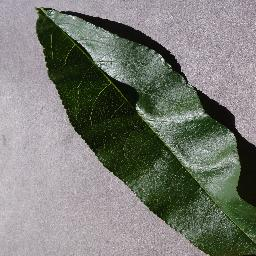

In [63]:
image_pil = Image.open('./archive/PlantVillage/train/Peach___healthy/500b93fd-f11f-4170-8752-966068f57188___Rutg._HL 2502.JPG')
display(image_pil)

## Pré-processando das Imagens

### Criando Mapeamento de Índices

In [64]:
labels = []

for subdir in os.listdir(base_dir):
    if os.path.isdir(base_dir):
        subdir_path = os.path.join(base_dir, subdir)
        for dir_1 in os.listdir(subdir_path):
            if os.path.isdir(subdir_path):
                dir_1_path = os.path.join(subdir_path, dir_1)
                for dir_2 in os.listdir(dir_1_path):
                    if 'train' in dir_1_path:
                        labels.append(dir_2)

In [65]:
labels

['Tomato___Spider_mites Two-spotted_spider_mite',
 'Peach___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Tomato___Target_Spot',
 'Strawberry___Leaf_scorch',
 'Pepper,_bell___Bacterial_spot',
 'Blueberry___healthy',
 'Cherry_(including_sour)___healthy',
 'Tomato___healthy',
 'Tomato___Leaf_Mold',
 'Potato___healthy',
 'Apple___Black_rot',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Peach___Bacterial_spot',
 'Tomato___Late_blight',
 'Apple___Cedar_apple_rust',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Grape___Esca_(Black_Measles)',
 'Apple___healthy',
 'Raspberry___healthy',
 'Grape___Black_rot',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Tomato___Septoria_leaf_spot',
 'Corn_(maize)___healthy',
 'Soybean___healthy',
 'Apple___Apple_scab',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Tomato___Early_blight',
 'Pepper,_bell___healthy',
 'Tomato___Tomato_mosaic_virus',
 'Corn_(maize)___Common_rust_',
 'Cherry_(including_sour)___Powde

In [66]:
len(labels)

38

In [67]:
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [68]:
label2id

{'Tomato___Spider_mites Two-spotted_spider_mite': 0,
 'Peach___healthy': 1,
 'Orange___Haunglongbing_(Citrus_greening)': 2,
 'Tomato___Target_Spot': 3,
 'Strawberry___Leaf_scorch': 4,
 'Pepper,_bell___Bacterial_spot': 5,
 'Blueberry___healthy': 6,
 'Cherry_(including_sour)___healthy': 7,
 'Tomato___healthy': 8,
 'Tomato___Leaf_Mold': 9,
 'Potato___healthy': 10,
 'Apple___Black_rot': 11,
 'Potato___Early_blight': 12,
 'Potato___Late_blight': 13,
 'Peach___Bacterial_spot': 14,
 'Tomato___Late_blight': 15,
 'Apple___Cedar_apple_rust': 16,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 17,
 'Grape___Esca_(Black_Measles)': 18,
 'Apple___healthy': 19,
 'Raspberry___healthy': 20,
 'Grape___Black_rot': 21,
 'Corn_(maize)___Northern_Leaf_Blight': 22,
 'Tomato___Septoria_leaf_spot': 23,
 'Corn_(maize)___healthy': 24,
 'Soybean___healthy': 25,
 'Apple___Apple_scab': 26,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 27,
 'Grape___healthy': 28,
 'Tomato___Early_blight': 29,
 'Pepper,_bell_

In [69]:
id2label

{0: 'Tomato___Spider_mites Two-spotted_spider_mite',
 1: 'Peach___healthy',
 2: 'Orange___Haunglongbing_(Citrus_greening)',
 3: 'Tomato___Target_Spot',
 4: 'Strawberry___Leaf_scorch',
 5: 'Pepper,_bell___Bacterial_spot',
 6: 'Blueberry___healthy',
 7: 'Cherry_(including_sour)___healthy',
 8: 'Tomato___healthy',
 9: 'Tomato___Leaf_Mold',
 10: 'Potato___healthy',
 11: 'Apple___Black_rot',
 12: 'Potato___Early_blight',
 13: 'Potato___Late_blight',
 14: 'Peach___Bacterial_spot',
 15: 'Tomato___Late_blight',
 16: 'Apple___Cedar_apple_rust',
 17: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 18: 'Grape___Esca_(Black_Measles)',
 19: 'Apple___healthy',
 20: 'Raspberry___healthy',
 21: 'Grape___Black_rot',
 22: 'Corn_(maize)___Northern_Leaf_Blight',
 23: 'Tomato___Septoria_leaf_spot',
 24: 'Corn_(maize)___healthy',
 25: 'Soybean___healthy',
 26: 'Apple___Apple_scab',
 27: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 28: 'Grape___healthy',
 29: 'Tomato___Early_blight',
 30: 'Pepper,_b

### Organizando as Imagens e os Rótulos

In [70]:
leaves = {'train': [], 'val': []}

for subdir in os.listdir(base_dir):
    if os.path.isdir(base_dir):
        subdir_path = os.path.join(base_dir, subdir)
        for dir_1 in os.listdir(subdir_path):
            if os.path.isdir(subdir_path):
                dir_1_path = os.path.join(subdir_path, dir_1)
                for dir_2 in os.listdir(dir_1_path):
                    if os.path.isdir(dir_1_path):
                        dir_2_path = os.path.join(dir_1_path, dir_2)
                        for image in os.listdir(dir_2_path):
                            if os.listdir(dir_2_path):
                                image_path = os.path.join(dir_2_path, image)
                                if os.path.isfile(image_path):
                                    #with Image.open(image_path) as image_pil:
                                    if 'train' in dir_2_path:
                                        tmp = {'image': image_path, 'label': label2id[dir_2]}
                                        leaves['train'].append(tmp)
                                    elif 'val' in dir_2_path:
                                        tmp = {'image': image_path, 'label': label2id[dir_2]}
                                        leaves['val'].append(tmp)

In [71]:
len(leaves['val'])

10861

In [72]:
len(leaves['train'])

43444

In [73]:
leaves['train'][:5]

[{'image': './archive/PlantVillage/train/Tomato___Spider_mites Two-spotted_spider_mite/7a08fe90-da9a-41a0-99f0-5952625a83bb___Com.G_SpM_FL 1371.JPG',
  'label': 0},
 {'image': './archive/PlantVillage/train/Tomato___Spider_mites Two-spotted_spider_mite/0f6a5f32-3d95-4ef1-bc01-ba36f2efb2b4___Com.G_SpM_FL 1661.JPG',
  'label': 0},
 {'image': './archive/PlantVillage/train/Tomato___Spider_mites Two-spotted_spider_mite/a8095d03-62bd-4a7e-b4df-f385f809bbc8___Com.G_SpM_FL 8637.JPG',
  'label': 0},
 {'image': './archive/PlantVillage/train/Tomato___Spider_mites Two-spotted_spider_mite/6ad11f4a-0932-412b-86bb-df6f9a7f3dae___Com.G_SpM_FL 9549.JPG',
  'label': 0},
 {'image': './archive/PlantVillage/train/Tomato___Spider_mites Two-spotted_spider_mite/c6f23183-e089-4758-9f8a-a8f702e28336___Com.G_SpM_FL 8646.JPG',
  'label': 0}]

In [74]:
leaves['val'][:5]

[{'image': './archive/PlantVillage/val/Tomato___Spider_mites Two-spotted_spider_mite/772aa86e-e26a-4e4e-bcfc-244984f94580___Com.G_SpM_FL 1627.JPG',
  'label': 0},
 {'image': './archive/PlantVillage/val/Tomato___Spider_mites Two-spotted_spider_mite/a74561dc-37d9-407f-bb58-596344859fa3___Com.G_SpM_FL 8517.JPG',
  'label': 0},
 {'image': './archive/PlantVillage/val/Tomato___Spider_mites Two-spotted_spider_mite/4d19f5b1-d82b-437d-936e-5afaa8ebb885___Com.G_SpM_FL 1390.JPG',
  'label': 0},
 {'image': './archive/PlantVillage/val/Tomato___Spider_mites Two-spotted_spider_mite/2150b3d6-e3fe-4a45-8355-107954d843c8___Com.G_SpM_FL 8578.JPG',
  'label': 0},
 {'image': './archive/PlantVillage/val/Tomato___Spider_mites Two-spotted_spider_mite/f4a12c44-b3a8-4419-b34e-ae6bdfa7d765___Com.G_SpM_FL 9521.JPG',
  'label': 0}]

### Embaralhando os Dados de Treino

In [75]:
random.shuffle(leaves['train'])

In [76]:
leaves['train'][:5]

[{'image': './archive/PlantVillage/train/Grape___Esca_(Black_Measles)/79823d7a-f18b-425b-986d-b0e10e252c71___FAM_B.Msls 3961.JPG',
  'label': 18},
 {'image': './archive/PlantVillage/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/e030230a-e378-4ccd-b086-17710f52cec1___YLCV_NREC 0127.JPG',
  'label': 34},
 {'image': './archive/PlantVillage/train/Tomato___Septoria_leaf_spot/595a0cc2-9889-4d21-a2a7-eebce965e141___Matt.S_CG 7400.JPG',
  'label': 23},
 {'image': './archive/PlantVillage/train/Orange___Haunglongbing_(Citrus_greening)/01b1393d-79fc-4333-bf2c-d18303903c5a___CREC_HLB 7820.JPG',
  'label': 2},
 {'image': './archive/PlantVillage/train/Soybean___healthy/7b68c9f9-471d-4f77-80f1-858e042e61e1___RS_HL 7180.JPG',
  'label': 25}]

### Convertendo o Estrutura dos Dados

In [77]:
train_dataset = Dataset.from_dict({'image': [leaves['train'][i]['image'] for i in range(len(leaves['train']))],
                                   'label': [leaves['train'][i]['label'] for i in range(len(leaves['train']))]})
val_dataset = Dataset.from_dict({'image': [leaves['val'][i]['image'] for i in range(len(leaves['val']))],
                                   'label': [leaves['val'][i]['label'] for i in range(len(leaves['val']))]})

In [78]:
leaves = DatasetDict({'train': train_dataset, 'val': val_dataset})

In [79]:
leaves['train'][:5]

{'image': ['./archive/PlantVillage/train/Grape___Esca_(Black_Measles)/79823d7a-f18b-425b-986d-b0e10e252c71___FAM_B.Msls 3961.JPG',
  './archive/PlantVillage/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/e030230a-e378-4ccd-b086-17710f52cec1___YLCV_NREC 0127.JPG',
  './archive/PlantVillage/train/Tomato___Septoria_leaf_spot/595a0cc2-9889-4d21-a2a7-eebce965e141___Matt.S_CG 7400.JPG',
  './archive/PlantVillage/train/Orange___Haunglongbing_(Citrus_greening)/01b1393d-79fc-4333-bf2c-d18303903c5a___CREC_HLB 7820.JPG',
  './archive/PlantVillage/train/Soybean___healthy/7b68c9f9-471d-4f77-80f1-858e042e61e1___RS_HL 7180.JPG'],
 'label': [18, 34, 23, 2, 25]}

In [80]:
leaves['val'][:5]

{'image': ['./archive/PlantVillage/val/Tomato___Spider_mites Two-spotted_spider_mite/772aa86e-e26a-4e4e-bcfc-244984f94580___Com.G_SpM_FL 1627.JPG',
  './archive/PlantVillage/val/Tomato___Spider_mites Two-spotted_spider_mite/a74561dc-37d9-407f-bb58-596344859fa3___Com.G_SpM_FL 8517.JPG',
  './archive/PlantVillage/val/Tomato___Spider_mites Two-spotted_spider_mite/4d19f5b1-d82b-437d-936e-5afaa8ebb885___Com.G_SpM_FL 1390.JPG',
  './archive/PlantVillage/val/Tomato___Spider_mites Two-spotted_spider_mite/2150b3d6-e3fe-4a45-8355-107954d843c8___Com.G_SpM_FL 8578.JPG',
  './archive/PlantVillage/val/Tomato___Spider_mites Two-spotted_spider_mite/f4a12c44-b3a8-4419-b34e-ae6bdfa7d765___Com.G_SpM_FL 9521.JPG'],
 'label': [0, 0, 0, 0, 0]}

### Carregando o Modelo e o Processador

In [81]:
modelo_hf = 'google/vit-base-patch16-224-in21k'

In [82]:
processor = AutoImageProcessor.from_pretrained(modelo_hf)

In [83]:
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [84]:
mean, std = processor.image_mean, processor.image_std

In [85]:
mean

[0.5, 0.5, 0.5]

In [86]:
std

[0.5, 0.5, 0.5]

In [87]:
height, width = processor.size['height'], processor.size['width']

In [88]:
height

224

In [89]:
width

224

In [90]:
scale = processor.rescale_factor

In [91]:
scale

0.00392156862745098

In [92]:
#Função de aumento e normalização dos dados
train_data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(height, width),
    tf.keras.layers.Normalization(mean=mean, variance=[s**2 for s in std]),
    tf.keras.layers.Rescaling(scale= scale),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(factor=0.2),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
], name = 'train_data_augmentation')

val_data_augmentation = tf.keras.Sequential([
    tf.keras.layers.CenterCrop(height, width),
    tf.keras.layers.Normalization(mean=mean, variance=[s**2 for s in std]),
    tf.keras.layers.Rescaling(scale=scale)
], name='val_data_augmentation')

In [93]:
# Função para converter para tf.tensor
def convert_to_tensor(path_image):
    image = Image.open(path_image)
    image_rgb = image.convert('RGB')
    np_image = np.array(image_rgb)
    tf_image = tf.convert_to_tensor(np_image, dtype=tf.float32)
    return tf.expand_dims(tf_image, 0)

In [94]:
# Função para aplicar as transformações aos dados de treino e validação
def preprocess_train(batch):
    images = [
        train_data_augmentation(convert_to_tensor(path_image)) for path_image in batch['image']
    ]
    batch['pixel_values'] = [tf.transpose(tf.squeeze(image)) for image in images]
    return batch

def preprocess_val(batch):
    images = [
        val_data_augmentation(convert_to_tensor(path_image)) for path_image in batch['image']
    ]
    batch['pixel_values'] = [tf.transpose(tf.squeeze(image)) for image in images]
    return batch

In [95]:
leaves['train'].set_transform(preprocess_train)
leaves['val'].set_transform(preprocess_val)

In [96]:
leaves["train"][0]

{'image': './archive/PlantVillage/train/Grape___Esca_(Black_Measles)/79823d7a-f18b-425b-986d-b0e10e252c71___FAM_B.Msls 3961.JPG',
 'label': 18,
 'pixel_values': <tf.Tensor: shape=(3, 224, 224), dtype=float32, numpy=
 array([[[0.6607121 , 0.42088467, 0.31721684, ..., 1.4062463 ,
          1.4219462 , 1.4539586 ],
         [0.6556052 , 0.4680105 , 0.4097039 , ..., 1.2931327 ,
          1.298896  , 1.3508343 ],
         [0.69516385, 0.45080486, 0.36762723, ..., 1.2629174 ,
          1.2441052 , 1.2468486 ],
         ...,
         [0.6354668 , 0.64120626, 0.57240206, ..., 1.0860934 ,
          1.2710816 , 1.3512124 ],
         [0.7014925 , 0.65819985, 0.60193616, ..., 1.2101308 ,
          1.159045  , 1.1013806 ],
         [0.689774  , 0.7160413 , 0.6858247 , ..., 1.4055777 ,
          1.2466352 , 0.96820873]],
 
        [[0.4844417 , 0.29703587, 0.25647154, ..., 1.327815  ,
          1.3435148 , 1.3755273 ],
         [0.4375794 , 0.3198922 , 0.3367695 , ..., 1.2147014 ,
          1.220464

In [97]:
leaves['val'][0]

{'image': './archive/PlantVillage/val/Tomato___Spider_mites Two-spotted_spider_mite/772aa86e-e26a-4e4e-bcfc-244984f94580___Com.G_SpM_FL 1627.JPG',
 'label': 0,
 'pixel_values': <tf.Tensor: shape=(3, 224, 224), dtype=float32, numpy=
 array([[[1.0862746 , 1.0078433 , 1.        , ..., 1.3215687 ,
          1.2509805 , 1.2901962 ],
         [0.9843138 , 0.97647065, 0.9215687 , ..., 1.4941177 ,
          1.1882354 , 1.1490197 ],
         [0.9686275 , 0.8352942 , 0.9450981 , ..., 1.3450981 ,
          1.2117648 , 1.2901962 ],
         ...,
         [0.9058824 , 0.93725497, 0.8588236 , ..., 1.4862746 ,
          1.4862746 , 1.4313726 ],
         [0.86666673, 0.8745099 , 0.82745105, ..., 1.4156864 ,
          1.5176471 , 1.5411766 ],
         [0.9921569 , 0.86666673, 1.        , ..., 1.4862746 ,
          1.5019609 , 1.4078432 ]],
 
        [[0.9921569 , 0.91372555, 0.9058824 , ..., 1.2352942 ,
          1.164706  , 1.2039217 ],
         [0.89019614, 0.882353  , 0.82745105, ..., 1.4078432 ,
  

### Definindo o Coletor de Dados Padrão

In [98]:
data_collator = DefaultDataCollator(return_tensors='tf')

## Definindo Argumentos e Hiperparâmetros do Fine-Tuning

### Avaliação Durante o Treinamento

In [99]:
accuracy = evaluate.load('accuracy')

In [100]:
def compute_metrics(eval):
    predictions, labels = eval
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

### Otimizadores e Agendadores de Taxa de Aprendizado

In [101]:
batch_size = 32
num_epochs = 3
num_train_steps = len(leaves['train']) * num_epochs
lr = 5e-5
weight_decay_rate = 0.01

optimizer, lr_scheduler = create_optimizer(
    init_lr= lr,
    num_train_steps = num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

optimizer.learning_rate = lr_scheduler

### Carregamento do Modelo com os Rótulos

In [102]:
model = TFAutoModelForImageClassification.from_pretrained(
    modelo_hf,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes = True
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Convertendo para Tensorflow Dataset

In [103]:
train_dataset = leaves['train'].to_tf_dataset(
    columns='pixel_values', label_cols='label', shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

eval_dataset = leaves['val'].to_tf_dataset(
    columns='pixel_values', label_cols='label', shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

### Configurando o Compilador

In [104]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

### Configurando a Chamada de Volta

In [105]:
metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=eval_dataset)
callback = [metric_callback]

## Treinamento do Modelo

In [106]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_dataset,
        validation_data=eval_dataset,
        epochs=num_epochs,
        callbacks=callback
    )

Epoch 1/3
1357/1358 [============================>.] - ETA: 1s - loss: 0.6329

W0000 00:00:1721254631.664910   35255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721254631.666411   35255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721254631.668139   35255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721254631.669642   35255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721254631.671165   35255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721254631.672875   35255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721254631.674582   35255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721254631.676231   35255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721254631.677976   35255 gp

1358/1358 [==============================] - ETA: 0s - loss: 0.6327

W0000 00:00:1721254632.155507   35254 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721254632.157556   35254 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721254632.159655   35254 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721254632.162420   35254 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721254632.164208   35254 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721254632.166478   35254 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721254632.168877   35254 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721254632.170614   35254 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721254632.172385   35254 gp

1358/1358 [==============================] - 2037s 1s/step - loss: 0.6327 - val_loss: 0.1174 - accuracy: 0.9819
Epoch 2/3


2024-07-17 19:22:00.597178: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1358/1358 [==============================] - 2021s 1s/step - loss: 0.0686 - val_loss: 0.0370 - accuracy: 0.9930
Epoch 3/3


2024-07-17 19:55:41.464772: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1358/1358 [==============================] - 2026s 1s/step - loss: 0.0358 - val_loss: 0.0545 - accuracy: 0.9867


In [119]:
image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

In [120]:
model.save_pretrained("final_model")
image_processor.save_pretrained("final_model")

['final_model/preprocessor_config.json']

In [3]:
classifier = pipeline("image-classification", model='final_model')

I0000 00:00:1721342071.029153    4898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721342071.056895    4898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721342071.057277    4898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721342071.059608    4898 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [6]:
classifier('images_teste/image0.jpg')[0]

{'label': 'Raspberry___healthy', 'score': 0.9719454050064087}

In [125]:
processor_image = AutoImageProcessor.from_pretrained('final_model/preprocessor_config.json')

In [147]:
inputs = processor_image(Image.open('images_teste/image1.jpg'), return_tensors='tf')

In [132]:
modelo = TFViTForImageClassification.from_pretrained("final_model")

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at final_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [148]:
logits = modelo(**inputs).logits

In [149]:
predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
model.config.id2label[predicted_class_id]

'Blueberry___healthy'